In [1]:
import bilinear
from keras import models, applications

Using TensorFlow backend.


In [2]:
# Note: if you want weights to be seperately trainable, need to instantiate two models
base_vggA = applications.vgg19.VGG19(include_top=False)
base_vggA.summary()

base_vggB = applications.vgg19.VGG19(include_top=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
# note that these will have the same output_shape for a given input_shape
modelA = models.Model(inputs=base_vggA.input,
                      outputs=base_vggA.get_layer('block5_conv4').output)

modelB = models.Model(inputs=base_vggB.input, 
                      outputs=base_vggB.get_layer('block5_conv3').output)

## Asymmetric BCNN Example

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             20024384    input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 multiple             17664576    input_3[0][0]                    
__________________________________________________________________________________________________
bilinear_pooling (Lambda)       (None, 512, 512)     0           model_1[1][0]                    
                                                                 model_2[1][0]                    
__________

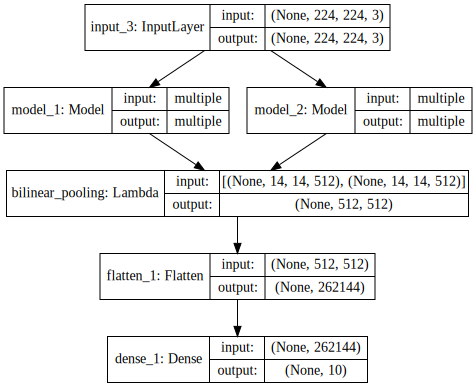

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

asymm_model = bilinear.combine(modelA, modelB, (224, 224, 3), 10)
asymm_model.summary()

SVG(model_to_dot(asymm_model, show_shapes=True).create(prog='dot', format='svg'))

## Symmetric BCNN Example

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             20024384    input_4[0][0]                    
__________________________________________________________________________________________________
bilinear_pooling (Lambda)       (None, 512, 512)     0           model_1[2][0]                    
                                                                 model_1[2][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 262144)       0           bilinear_pooling[0][0]           
__________

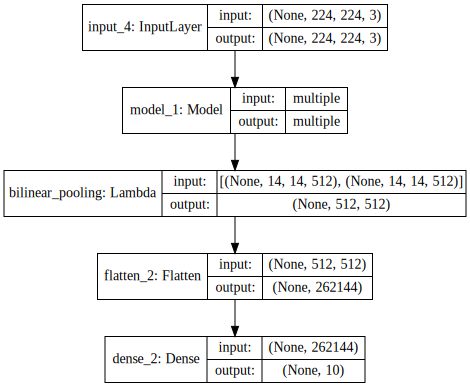

In [5]:
symm_model = bilinear.combine(modelA, None, (224, 224, 3), 10)
symm_model.summary()

SVG(model_to_dot(symm_model, show_shapes=True).create(prog='dot', format='svg'))

## Asymmetric with VGG19 + Xception

In [ ]:
base_xcp = applications.xception.Xception(include_top=False, input_shape=(224,224,3))

In [20]:
# just print activation layers for readability
def print_fn(l):
    if 'Act' in l:
        print(l)
        
base_xcp.summary(print_fn=print_fn)

block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
block1_conv2_act (Activation)   (None, 109, 109, 64) 0           block1_conv2_bn[0][0]            
block2_sepconv2_act (Activation (None, 109, 109, 128 0           block2_sepconv1_bn[0][0]         
block3_sepconv1_act (Activation (None, 55, 55, 128)  0           add_49[0][0]                     
block3_sepconv2_act (Activation (None, 55, 55, 256)  0           block3_sepconv1_bn[0][0]         
block4_sepconv1_act (Activation (None, 28, 28, 256)  0           add_50[0][0]                     
block4_sepconv2_act (Activation (None, 28, 28, 728)  0           block4_sepconv1_bn[0][0]         
block5_sepconv1_act (Activation (None, 14, 14, 728)  0           add_51[0][0]                     
block5_sepconv2_act (Activation (None, 14, 14, 728)  0           block5_sepconv1_bn[0][0]         
block5_sepconv3_act (Activation (None, 14, 14, 728)  0           block5_sepconv2_bn[0][0]         
block6_sep

In [21]:
modelX = models.Model(inputs=base_xcp.input,
                     outputs=base_xcp.get_layer('block13_sepconv2_act').output)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             20024384    input_10[0][0]                   
__________________________________________________________________________________________________
model_5 (Model)                 (None, 14, 14, 728)  14599824    input_10[0][0]                   
__________________________________________________________________________________________________
bilinear_pooling (Lambda)       (None, 512, 728)     0           model_1[3][0]                    
                                                                 model_5[1][0]                    
__________

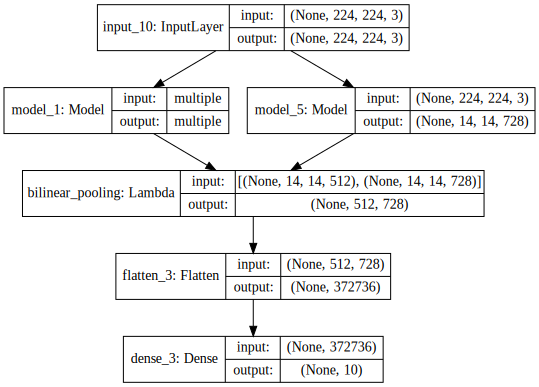

In [22]:
dual_model = bilinear.combine(modelA, modelX, (224, 224, 3), 10)
dual_model.summary()

SVG(model_to_dot(dual_model, show_shapes=True).create(prog='dot', format='svg'))